# Image Segmentation for Remote Sensing

Remote sensing involves acquiring information about objects or areas from a distance, often through aircraft or satellites. This project focuses on labeling house roofs using image segmentation based on satellite images. What makes this project intriguing is the constraint of having only a limited set of labeled images (around 20). Addressing this challenge necessitates the application of **transfer learning** techniques.


##  google colab
The following cell should be only implemented on google colab to address inconsistencies regarding the segmentation_models module.

In [1]:
from google.colab import files
files.upload()


!unzip data.zip


import numpy as np
from matplotlib import pyplot as plt

!pip install -U -q segmentation-models
!pip install -q tensorflow==2.12.0
!pip install -q keras==2.12.0
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Saving data.zip to data.zip
Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/images/
  inflating: __MACOSX/data/._images  
   creating: data/labels/
  inflating: __MACOSX/data/._labels  
  inflating: data/dida_test_task (1).zip  
  inflating: __MACOSX/data/._dida_test_task (1).zip  
   creating: data/unlabeled/
  inflating: __MACOSX/data/._unlabeled  
  inflating: data/images/417.png     
  inflating: __MACOSX/data/images/._417.png  
  inflating: data/images/317.png     
  inflating: __MACOSX/data/images/._317.png  
  inflating: data/images/303.png     
  inflating: __MACOSX/data/images/._303.png  
  inflating: data/images/328.png     
  inflating: __MACOSX/data/images/._328.png  
  inflating: data/images/300.png     
  inflating: __MACOSX/data/images/._300.png  
  inflating: data/images/314.png     
  inflating: __MACOSX/data/images/._314.png  
  inflating: data/

# Reading the data
Here I read the images and the masks. The alpha channel is removed from the sRGB images. The unlabeled data is saved in a seperate directory. The original data is provided by and available on https://dida.do/downloads/dida-test-task and also https://github.com/jeradhoy/DeepSatelliteData?tab=readme-ov-file.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import imageio


%matplotlib inline



# reading the data
path = ''
image_path = os.path.join(path, './data/images/')
mask_path = os.path.join(path, './data/labels/')
unlabeled_path = os.path.join(path, './data/unlabeled/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
unlabeled_list = os.listdir(unlabeled_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
unlabeled_list = [unlabeled_path+i for i in unlabeled_list]


images = []
masks = []
unlabeled = []


for i in range(len(mask_list)):
    img = imageio.imread(image_list[i])
    mask = imageio.imread(mask_list[i])
    mask = np.where(mask>0,1,0) # mask values are 0 or one
    images.append(img[:,:,:3]/255.) # we remove the alpha channel
    masks.append(mask.reshape((256,256,1)))
    
    
for i in range(len(unlabeled_list)):
    img = imageio.imread(unlabeled_list[i])
    unlabeled.append(img[:,:,:3]/255)

    
    
images, masks, unlabeled = np.array(images), np.array(masks), np.array(unlabeled)    

print(image_list)
print(mask_list)
print(unlabeled_list)





<ipython-input-2-70ce68840381>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[i])
<ipython-input-2-70ce68840381>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[i])
<ipython-input-2-70ce68840381>:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(unlabeled_list[i])


['./data/images/287.png', './data/images/308.png', './data/images/345.png', './data/images/317.png', './data/images/270.png', './data/images/379.png', './data/images/315.png', './data/images/274.png', './data/images/417.png', './data/images/301.png', './data/images/343.png', './data/images/314.png', './data/images/320.png', './data/images/121.png', './data/images/300.png', './data/images/337.png', './data/images/303.png', './data/images/324.png', './data/images/532.png', './data/images/328.png', './data/images/272.png', './data/images/381.png', './data/images/241.png', './data/images/284.png']
['./data/labels/287.png', './data/labels/308.png', './data/labels/345.png', './data/labels/317.png', './data/labels/270.png', './data/labels/379.png', './data/labels/315.png', './data/labels/274.png', './data/labels/417.png', './data/labels/301.png', './data/labels/343.png', './data/labels/314.png', './data/labels/320.png', './data/labels/121.png', './data/labels/300.png', './data/labels/337.png'

# Plotting the data

The labeled data are plotted. Here I noticed that the image 278.png is labeld very bad. So I removed it from the labeled data and put it in the unlabeled data.

./data/images/345.png ./data/labels/345.png
2


Text(0.5, 1.0, 'Segmentation')

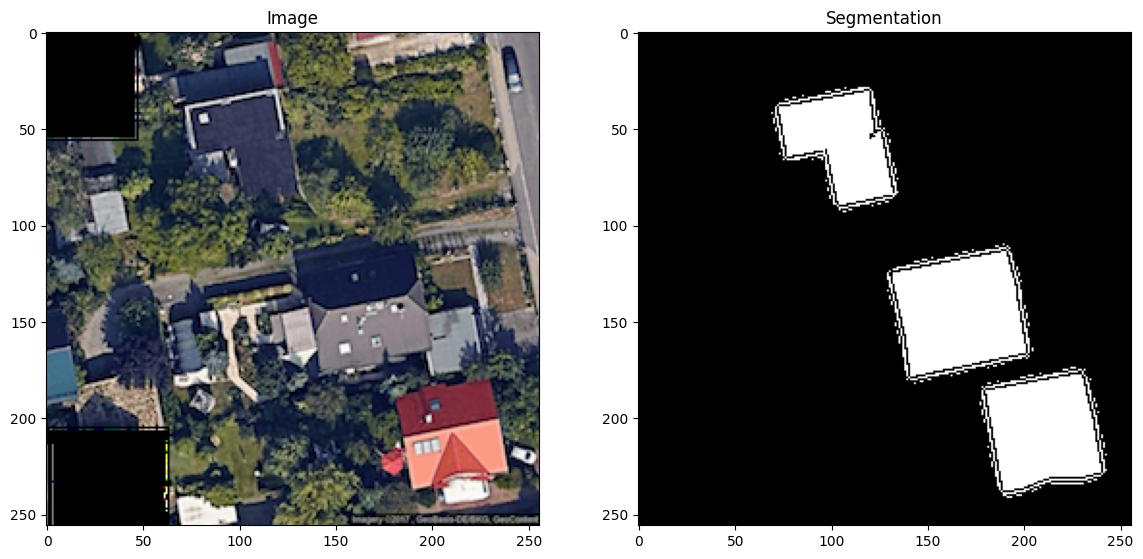

In [6]:
i = np.random.randint(0, len(image_list))
img, mask = images[i], masks[i]
mask = mask.reshape((256,256,1))

print(image_list[i], mask_list[i])
print(i)
i+=1

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='gray')
arr[1].set_title('Segmentation')




# segmentation_models

In order to do transfer learning for segmentation, we here use the "segmentation_models" module available on https://segmentation-models.readthedocs.io/en/latest/tutorial.html . The module works extraordinarily well for such a purpose. All the preprocessing and transfer learnings are performed automatically. 

In [7]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import random
import numpy as np


BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input to be consistent with the trained network 
images_pro=preprocess_input1(images)


# test-train split
X_train, X_test, y_train, y_test = train_test_split(images_pro, masks, test_size = 0.2, random_state = 101)
print(X_train.shape)
print(X_test.shape)

(19, 256, 256, 3)
(5, 256, 256, 3)


# Data Augmentation

We here define a generator for data augmentation. Indeed I found the following generator definition in the page of Sreenivas B. at https://github.com/bnsreenu/python_for_microscopists .

In [8]:
from keras.preprocessing.image import ImageDataGenerator
seed=101


image_data_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3,
                     shear_range=0.5, zoom_range=0.3, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.3, height_shift_range=0.3,
                     shear_range=0.5, zoom_range=0.3, horizontal_flip=True,vertical_flip=True, fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)


def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

        
        
my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


# Model

The number of epochs is determined by the value at which the IOU of the test set reaches a reasonable stable value.

In [9]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

#Fit the model
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50,epochs=80)


85521592/85521592 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

## Loss function

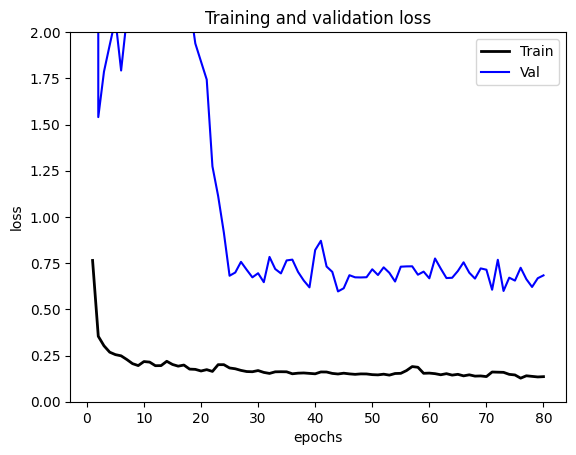

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'k', lw=2, label='Train')
plt.plot(epochs, val_loss, 'b', label='Val')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0,2)
plt.legend()
plt.show()


## IOU score

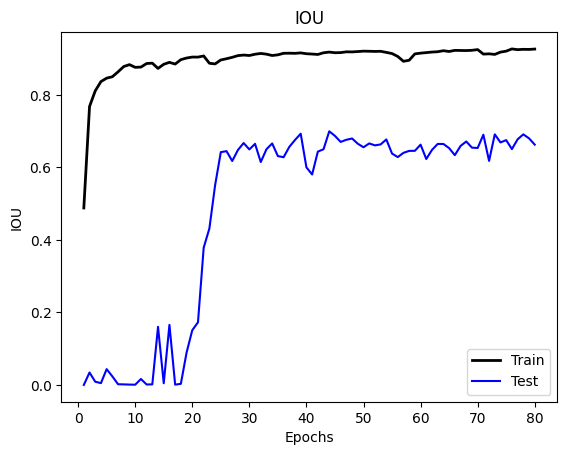

<Figure size 640x480 with 0 Axes>

In [16]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'k', lw=2, label='Train')
plt.plot(epochs, val_acc, 'b', label='Test')
plt.title('IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()
plt.savefig("IOU.pdf")

## Checking the prediction for a random labeled image

1/1 [==============================] - 0s 24ms/step
IoU socre is:  0.692851076970586
1/1 [==============================] - 0s 21ms/step


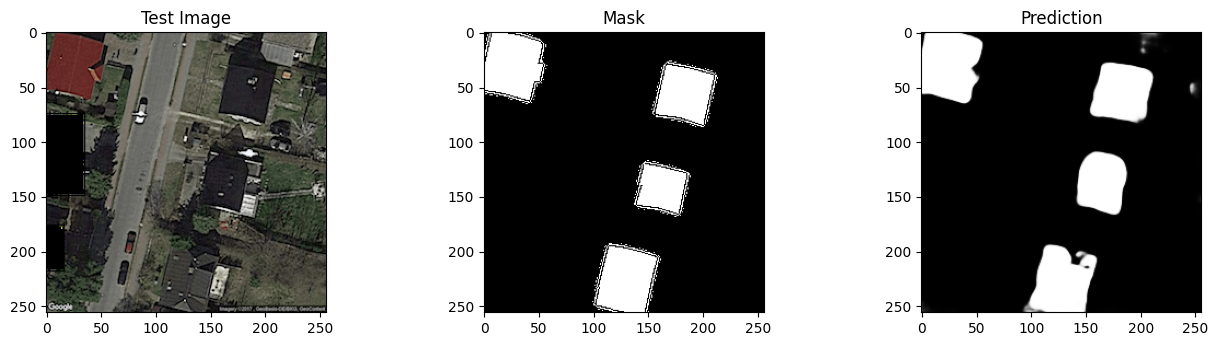

<Figure size 640x480 with 0 Axes>

In [34]:

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

N = random.randint(0, len(X_test)-1)
prediction = model.predict(np.expand_dims(X_test[N],0))


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(X_test[N])
plt.subplot(232)
plt.title('Mask')
plt.imshow(y_test[N], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction[0], cmap='gray')

plt.show()

plt.savefig("test.pdf")

## Checking the prediction for unlabeled images

1/1 [==============================] - 0s 48ms/step
(6, 256, 256, 1)


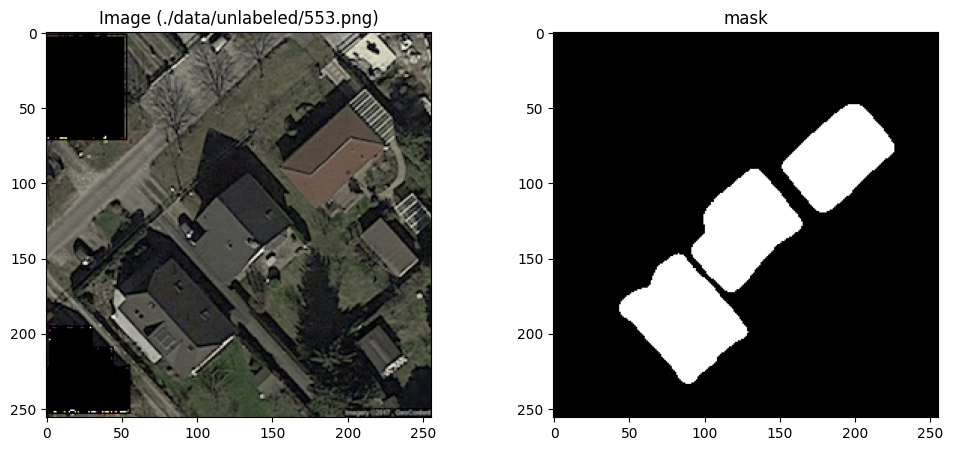

In [78]:
#IOU
unlabeled_pro = preprocess_input1(unlabeled)
prediction = model.predict(unlabeled_pro)
prediction = prediction > 0.5

print(prediction.shape)


N=5
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Image ('+ str(unlabeled_list[N]) + ')')
plt.imshow(unlabeled[N])
plt.subplot(122)
plt.title('mask')
plt.imshow(prediction[N], cmap='gray')
plt.show()

# plt.savefig("553.pdf")

In [68]:
ls 

278.pdf  537.pdf  551.pdf  data/     IOU.pdf  __MACOSX/     test.pdf
535.pdf  539.pdf  553.pdf  data.zip  IOU.png  sample_data/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>